# Week 10: Networks 2


Networks are mathematical representations of complex systems. We can use networks to gain various statistical insight about the system we're representing, and we can look for patterns at the meso-scale by employing *community detection* algorithms. This week we will explore the following:

* Network null models
* How to use a null model to infer the p-value of a result
* How a popular community detection algorithm works (and fails)

**Questions**: Outside of class, use [issue on GitHub](https://github.com/abjer/tsds/issues) for asking questions.

## Imports

In [2]:
%matplotlib inline
import matplotlib.pylab as plt
import networkx as nx           # `pip install networkx`
import json
from collections import Counter
import community                # `pip install python-louvain` or `conda install -c auto python-louvain
import pandas as pd
import seaborn as sns
plt.style.use('ggplot')

## Exercises

### Part 1: Network null models

**What is a null model?** Null models are alternative instances of data, that are used to assess the amount of signal that is due to pure randomness. For example, you might have
measured some signal in your data, like a large number of triangles (high average local clustering coefficient)
in your network, but before you go and report that to your boss you need to answer one crucial question: how does
this result compare with a *random* one? In other words, how can you be so sure that this high number of triangles
measured is not perfectly normal even in a random network of similar origin and therefore not very special after all? The answer: **you
create a null model to compare your result with!**

> Note: null models are a concept from the general field of statistics and therefore not just specific to
networks. You can use this statistical tool anytime you need to assess how likely it is that your result is random.

The most common type of null model is one where you shuffle links in your network, while preserving the degree
sequence. *(Recall, that the degree sequence is a list that stores the degree of each node. So if we shuffle and
preserve the degree sequence at the same time, it means that after all the link-shuffling is done, nodes will
have new neighbors, but the same number of neighbors)*. In this shuffled network (the null model), if you find that
there are far fewer triangles than in your real data then you can start to argue that your result is significant.

> Note: the term *null model* is a slight misnomer, as it is not a model per se, but rather an instance of the
data that is permuted in some way (usually under constraints, such as preservation of degree sequence), so it can
be taken to represent *randomness*. As such, there is no *model*, but rather an *instance* or simply *data*.

But that is just one comparison. What if the number of triangles in the random data–the null model–is smaller, but
not that much smaller? Can you still say your result is significant? Well, the trick (although computationally expensive
as you will come to learn) is to do MANY comparisons. 1000 is not a bad start. For each comparison, you check if
the number of triangles in your real data is bigger. After you have compared one thousand times you compute **the
fraction of times** your number of triangles in the real data was bigger than in the random data. Guess what that
number (between 0 and 1) is called? **The p-value**. And what does it communicate? **The probability that your result
is random!**

^ That's some useful statistics right there!

Please make sure you have **READ AND UNDERSTOOD** the above, as you will otherwise have a very hard time completing the
following exercises.

**Ex. 10.1.1**: The method described above works for anything you might want to measure in a network. Let's say,
instead of measuring the number of triangles, you measured the network diameter. Explain in your own words how to
assess the statistical significance (the p-value) of such a measurement, using the same null model.

**Answer 10.1.1**: As with the assessment of the number of triangles (The Average Local Cluster Coefficient), you would have to compare the original network to the average of a large number of random network. If the diameter of the real network is statistically different from the diameters of randomly constructed null models, we assess that the real network is non-random, as it seem to have a non-random diameter.

**Ex. 10.1.2**: The null model described above rewires a network while preserving the degree distribution. [Here](https://networkx.github.io/documentation/stable/reference/algorithms/generated/networkx.algorithms.swap.double_edge_swap.html#networkx.algorithms.swap.double_edge_swap) is
implementation of it in NetworkX. In your own words, describe:
1. how it works and why it achieves randomness
without changing the degree distribution.
2. Also describe what can sometimes happen and why the desired number of swaps `nswaps` is only an upper-bound on
the number of swaps.

***Answer 10.1.2.1***:
nx.double_edge_swap() takes a network (G) as input and returns a "random" network (G_rand) in which the links have been randomly swapped while the degree sequence has been preserved (each node has the same degree in G_rand as in G, but (probably) with different neighbours). It randomly chooses 2 edges and rearranges them (e.g. x-y and u-v will become x-u and y-v) unless the new edges already exists (that is if e.g. x and u (or y and v) were already linked before the swap). It achieves randomness while preserving the degree distribution by randomly choosing the edges to swap, though with the constraint that if one of the new edges already exists, none of the two new edges will be created. 

It also allow for 3 arguments
- `nswap`: How many swaps to perform (default=1, so if not specified, only a single edge pair will potentially get swapped)
- `max_tries`: Since it randomly chooses which edge pairs to swap, it might try to create new edges, which already exists. In that case, no swap is performed. `max_tries` is the upper-bound for how many times it is allowed to attempt to choose valid edge-pairs to swap until `nswap` is reached. Therefore `max_tries` > `nswap`.
- `seed`: the random number generator state - allows one to reconstruct the "random"
proces/outcome

***Answer 10.1.2.2***:
As mentioned aboved, it is not garanteed that `nswap`-swaps are actuallized by the algorithm due to the randomness of the selection process and the constraint on the new edge pairs. The algorithm will attempt to carry out `nswap`-swaps, but only for `max_tries`-attempts. Thus `nswap` is not garanteed, but merely the upper-bound/potential maximum swaps.

**Ex. 10.1.3**: Load the Facebook wall-post network from last week, into a `networkx.Graph` object called `G`.
1. Measure the average local clustering coefficient (ALCC) of `G`. Print it.
2. Over 1000 iterations, measure the ALCC for `G` where, in each iteration, you have made 1000 edge swaps using 
`double_edge_swap`. Append the measured ALCC values to a list. Print the average of this list. *Note: this will
obviously take some time**.
3. Report the p-value of your result, the ALCC of the real data.
4. Make a histogram that displays the distribution of ALCC values in the null models as a histogram as well as
the ALCC of the real data as a vertical line. Comment on this result. Does it make sense?

In [5]:
## 10.1.3.1
################################ LOAD AND SPECIFY THE FACEBOOK DATA #############################
data = pd.read_csv(
    "Ex_10/facebook-wall.txt",
    delimiter="\t",
    header=None,
    names=['user1', 'user2', 'timestamp']
)

## Full network (all data)
data_t = data.groupby(['user1', 'user2']).size().reset_index(name='weight')
G = nx.from_pandas_edgelist(data_t, 'user1', 'user2', 'weight', create_using=nx.Graph)

#Print average clustering coefficient (average of the fraction of realised triangles over potential triangles for each node.)
ALCC_real = nx.average_clustering(G)
print('Average clustering coefficient:', nx.average_clustering(G))

Average clustering coefficient: 0.10796398386235195


In [6]:
## 10.1.3.2 --> WITHOUT INPLACE
#Construct container
container_new = []
# Construct original network each time.
G = nx.from_pandas_edgelist(data_t, 'user1', 'user2', 'weight', create_using=nx.Graph)

for count, _ in enumerate(range(1000)):
    if (count % 200) == 0:
        print('Loop #:', count)
    # Reset G_loop each time --> double_edge_swap is inplace. 
    G_loop = G.copy()
    #G = nx.from_pandas_edgelist(data_t, 'user1', 'user2', 'weight', create_using=nx.Graph)
    #shuffle edge (seed==None as the process should be random/different each time)
    #max_tries is set to an abitrary number greater than nswap. 
    nx.double_edge_swap(G_loop, nswap = 1000, max_tries = 2000, seed = None)
    #Append ALCC to container
    container_new.append(nx.average_clustering(G_loop))
print('Average ALCC of null models:', sum(container_new)/len(container_new))

Loop #: 0
Loop #: 200
Loop #: 400
Loop #: 600
Loop #: 800
Average ALCC of null models: 0.10455414981084332


p_value: 0.0


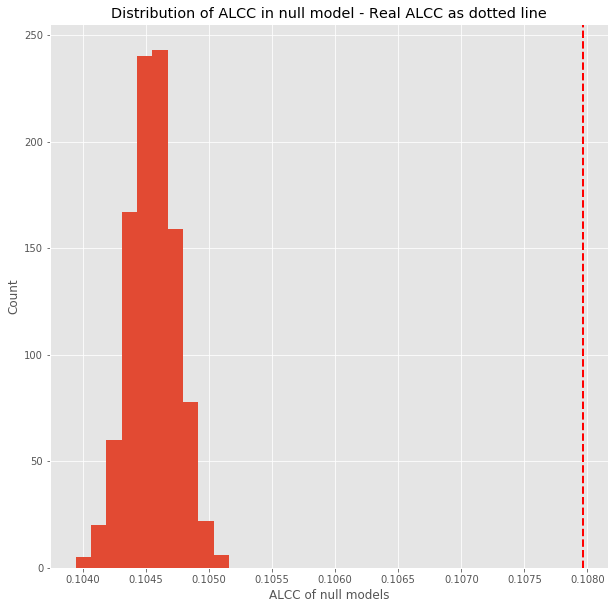

In [7]:
#List of ALCC_random < ALCC_real
smaller_ALCC_new = [ALCC_random for ALCC_random in container_new if ALCC_real < ALCC_random]

#p_value = fraction of times the ALCC of the real data is bigger than for the random data. 
p_value_new = len(smaller_ALCC_new)/len(container_new)
print('p_value:', p_value_new)
#Shouldn't it be 1 minus p_value which is the probability that the network is random? 
#Otherwise we get 100% probability that it IS random now...

#plot-histogram
fig, ax = plt.subplots(1,1, figsize = (10,10))
ax.hist(container_new)
ax.set_title('Distribution of ALCC in null model - Real ALCC as dotted line')
ax.set_xlabel('ALCC of null models')
ax.set_ylabel('Count')
#plt.xlim(left = min(container_new), right = (ALCC_real+ALCC_real*0.1))
ax.axvline(x=ALCC_real, color='r', linestyle='dashed', linewidth=2)
plt.show()

Judging by the histrogram and the p-value, it would appear as if the network is definintly ***not random***. The ALCC of the random networks were always smaller then the ALCC of the real network.

### Part 2: Community detection

Communities are little lumps of nodes in a network that are unusually strongly connected. Your family is a community, and your friend group from work or university is another community. While there is no one true definition of what a community is, there are many many different methods and algorithms for finding them. Here we will work with one of the most popular ones: [Louvain Modularity](https://en.wikipedia.org/wiki/Louvain_Modularity). The following exercises will walk you through the fundamentals of this method, and finally have you apply it to the network you used last week.

#### The modularity function

> **Ex. 10.2.1**: Assume you have a network where nodes and links tend to form lumps here and there. Imagine you now reach for your pen, and start labeling these nodes with group names (or ids) that feel appropriate according to how they are lumped together. If your partition is "good", nodes that are connected in groups should intuitively have the same label, while nodes that are distant and disconnected should have different labels. Modularity is a function that can be used to measure, by this logic, *how good* your partition is. It is in technical terms a *utility function*, and it looks like this:
> <br><br>
> $$ Q = \dfrac{1}{2m}\sum_{ij}{\left[A_{ij}-\dfrac{k_ik_j}{2m}\right]\delta(c_i, c_j)}.$$
> <br>
> Your job in this problem is to explain this equation. When I look at daunting math I find it calming to try and read it as if it were code. Since all math can be implemented in code, all math can be broken into parts, where each part does a seperate thing. Answer each question below seperately:
1. In code, a sum, $\sum$, is like a `for` loop, where in every iteration you increment a variable. In the equation for modularity the little $ij$ subscript tells is what the sum is looping over (like `for ij in sumloop`). But what is $ij$?
2. In each iteration of the sum, the delta function $\delta(c_i, c_j)$ is used, where $c_i$ is the community label of node $i$. The delta function is a very simple program that returns 0 if the two input values are different and 1 if they are they same. How would you implement the delta function in code? What is it used for in the modularity equation?
3. Inside the sum we use the term $\frac{k_ik_j}{2m}$ as our *null model*. $k$ is the degree sequence (so $k_i$ is the degree of node $i$) and $m$ is the sum of all link weights. Explain what this null model measures. Could we have used other null models?
4. The sum subtracts the null model from $A_{ij}$ and adds the result to its final value if the delta function evaluates to 1. What is the point of only summing over this difference when the delta function is 1?
5. The sum term is normalized by $2m$. Why exactly $2m$?
6. Summarize your insight gained from answering the above questions. In your own words, explain how the modularity function works. Use 1-3 sentences.


Answer:

**1)**: *ij* indicates a node pair, $node_i$ and $node_j$. So the sum is looping over all node pairs in the data.

**2)**: For each iteration over the node pairs *ij*, the component $\left[A_{ij}-\dfrac{k_ik_j}{2m}\right]$ only counts towards the modularity (which we want to maximize) if the two nodes are in the same community. We have coded the $\delta$ function below:


In [5]:
def delt(a,b):
    return int(a==b)
# Return either 1 (= True) or 0 (= False), dependent on whether node i and j are in the same counnity.

**3)**: $k_i$ and $k_j$ are the sum of the weights of the edges attached to nodes $i$ and $j$, respectively. $\dfrac{k_ik_j}{2m}$ ($p_{ij}$ in the book) is the expected weight of the link between nodes i, j under random degree-preserving. It is the expected number of connections (if the network is random/ under the null) divided by the total number of possible connections.


**4**): $\left[A_{ij}-\dfrac{k_ik_j}{2m}\right]$ measure the difference between the network’s real wiring diagram ($A_{ij}$) and the expected number of links between i and j if the network is randomly wired ($\dfrac{k_ik_j}{2m}$). 


**5**): $2m$ is the number of stubs available for connectivity in the network. The modularity is standardized by taking the size of the networks / it's degree sequence into account. 



**6)**: We don't really know - we found it difficult from here

> **Ex. 10.2.2**: Implement the modularity function. Write a Python function that takes as input an adjacency matrix and a label vector, and returns the modularity. Compute and print the modularity for the ones given below. The correct result is 0.122.

In [11]:
import numpy as np

A = np.array([
    [0, 1, 1, 0, 0, 0],
    [1, 0, 1, 0, 0, 0],
    [1, 1, 0, 1, 0, 0],
    [0, 0, 1, 0, 1, 1],
    [0, 0, 0, 1, 0, 1],
    [0, 0, 0, 1, 1, 0],
])

c = [0, 0, 0, 0, 1, 1]

def modularity(A, c):
    n = A.shape[0] # Matrix is symmetric
    Q = 0 # Set initial Q to 0
    m = A.sum() / 2 # Divide by 2 since we want the # of edges (A counts the # of stubs)
    for i in range(n): # Loop through all nodes - node_i
        ki = A[i,:].sum() # count degree (k_i) for node i.
        for j in range(n): # loop over all nodes --> node_j
            kj = A[:,j].sum() # count degress (k_j for node j
            Q += (A[i,j] - ki*kj/(2*m)) * delt(c[i], c[j]) #Add to total Q for nodepair i,j
    return Q/(2*m) # Standardize with 2*m and return final Q. 

print('Modularity of partition =', modularity(A,c))

Modularity of partition = 0.12244897959183675


> **Ex. 10.2.3**: The example labeling, `c`, was not optimal. Find the optimal one and print its modularity score.

>*Hint: Either just try a bunch of different label combinations or visualize the network so you can see what is optimal. Using pen and paper here is no shame.*

In [27]:
#Define helper function which assign new values without overwriting the original data
def put(array, index, value):
    _arr = array.copy() # set copy of input element
    _arr[index] = value # assign new value at a given index position
    return _arr # return the manipulated data

#Define louvain funtion
def louvain(A, max_iter = 50, k = 10):
    c = np.arange(A.shape[0]) # Assign each node to its own community
    Q = modularity(A,c) # Calculate modularity of the single-comminuty partition
    noimp = 0 # Used for check later.
    for _ in range(max_iter): # Loop that governs the maximum number of iterations
        if noimp > k: # if Q doesn't improve between iteration: noimp += 1.
                      # k is thus a threshold for how many iterations is allowed
                      # without an improvement in Q, before the loop/alogithm breaks.
            break # Break if no improvement to Q
        i = np.random.randint(A.shape[0]) # Choose random node
        js = np.where(A[i, :] == 1)[0] # extract each node (all the j's) that node i is linked to.
        
        #Compute the change in modularity when moving node i into the community of
        # each of it's neighbours -- Store the change in modularity in a list.
        # Loop through the neighbours (j's):
        delta_Qs = [modularity(A, put(c, i, c[j])) - Q for j in js]
        ###modularity(A, put(c, i, c[j])): use the put() function to reassign node i, to the 
        #community of node j, and then calculate the modularity. 
        ### - Q: subtract the modularity of the previous partition.
        
        
        #If the maximum change in modularity is <= 0, add 1 to noimp, and
        # continue to the next iteration of the loop.
        if max(delta_Qs) <= 0:
            noimp += 1
            continue
        # If the max change in modularity is > 0
        else:
            noimp = 0 # Reset noimp to 0
            j_star = js[np.argmax(delta_Qs)] # Take the neighbour, whose community yielded the greatest 
                                             # difference in modularity, when i was assigned to it. 
                
            c = put(c, i, c[j_star]) # Assign node i to the 'best' community
            old_Q = Q # Save the old Q, before overwriting (why?)
            Q = modularity(A, c) # Calculate new modularity, and proceed to next iteration.      
    return Q, c # return new class-labels

In [31]:
# Test how to best split A.
best_mod, best_class = louvain(A)

print('Modularity of best split:', best_mod)
print('Class labels of best split:', best_class)

Modularity of best split: 0.3571428571428571
Class labels of best split: [1 1 1 4 4 4]


#### Finding the best communities

OK, so we are now able to evaluate the quality of a partition. But how do we find the best partition? Modularity gives us a way to measure *how good* our partition is, but it does not tell of how to find the best one. For that we need some sort of algorithm. The *Louvain method* is that algorithm.

It works in the following steps:
1. Set every node to be its own community (initiate `c = [0, 1, 2, 3, 4, 5]`).
2. Compute the modularity.
3. Now pick a random node.
    1. For every neighbor it has, try giving it the neighbor's label, and compute the change in modularity.
    2. If any of those relabelings led to an increase in modularity, choose the relabeling with the greatest increase.
4. Repeat 2-3 until modularity ceases to increase for any relabelings.

***See Above (answer to 10.2.3)***

> **Ex. 10.2.BONUS**: Implement the Louvain method, and show that it gives the labeling for `A`. A cool portfolio project for your Github account here!

#### Communication communities on Facebook

Now let's work with some real data. Whip out the network you created **last week**, we will be using that again. Apply again the **threshold** you created in **Ex. 9.2.4**.

In [4]:
data = pd.read_csv(
    "facebook-wall.txt",
    delimiter="\t",
    header=None,
    names=['user1', 'user2', 'timestamp']
)

#Function to slice data - set how many days before last post for both upper and lower bound
def slice_data(t0_in=7, t1_in=0):
    t0 = data.timestamp.max() - 86400 * t0_in  # Lower bound of time-slice (t0_in days before last wall post)
    t1 = data.timestamp.max() - 86400 * t1_in   # Upper bound of time-slice (t1_in days before last wall post)

    # Subset of the pandas dataframe
    data_t = data.loc[data.timestamp.between(t0, t1)]

    # Count the number of times each link occurs and store that in a new 'weight' column
    data_t = data_t.groupby(['user1', 'user2']).size().reset_index(name='weight')

    # Create a `nx.DiGraph` from this dataframe
    G_t = nx.from_pandas_edgelist(data_t, 'user1', 'user2', 'weight', create_using=nx.Graph)
    return G_t

# Network of last 365 days
G_365 = slice_data(t0_in=365)

threshold = 1 

#Find threshold now that the graph is no longer directed
while (len(G_365.edges()) >= 20000 or len(G_365.nodes()) >= 5000):
    G_365 = slice_data(t0_in=365) # create the network
    if threshold % 5 == 0: # Keep track of loop
        print('Loop nr:', threshold)
    #set nodes to remove
    to_remove = [node for node,degree in G_365.degree() if degree < threshold]
    #Remove from network
    G_365.remove_nodes_from(to_remove)
    #Set new threshold
    threshold += 1 

#Create network
G_365 = slice_data(t0_in=365)

#Use threshold
to_remove = [node for node,degree in G_365.degree() if degree < threshold-1]
#Remove from network
G_365.remove_nodes_from(to_remove)
print(len(G_365.edges()), 'edges remain in the network')
print(len(G_365.nodes()), 'nodes remain in the network')

Loop nr: 5
Loop nr: 10
Loop nr: 15
Loop nr: 20
19625 edges remain in the network
2824 nodes remain in the network


> **Ex. 10.2.4**: Find the communities in this networks. Print the number of communities and plot the distribution of community sizes. See something interesting? Comment on this distribution.

>*Hint: You're welcome to use your own implementation of the Louvain algorithm (pretty badass if you can), but there's also a widely used Python implementation that you can take off the shelf. Go ahead and install `python-louvain` by running `conda install -c auto python-louvain` in a terminal. After installation, import it with `import community`, and use `community.best_partition` to get a node-community dictionary.*

There are 41 communities in the network


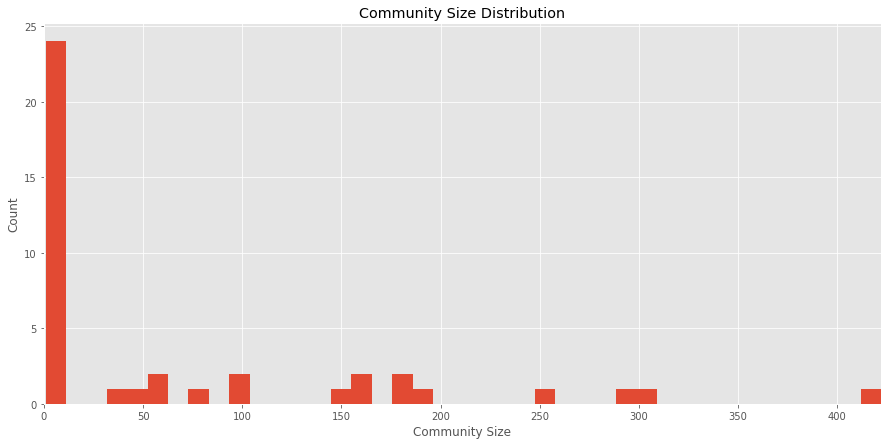

In [12]:
#Find communities/ partition network based on Louvain Modularity.
# Output = Dict with nodes as keys and community as values
partitions = community.best_partition(G_365)
#Extract the community of each node into list
community_list = [community for node,community in partitions.items()]
#Count how many nodes there are in the communities --> dict with community as key and count as value
com_count = Counter(community_list)
print('There are', len(com_count), 'communities in the network')

#Plot distribution of community size
fig, ax = plt.subplots(figsize = (15,7))
#Distribution plot of the size of the communities
ax.set_title("Community Size Distribution")
ax.set_ylabel("Count")
ax.set_xlabel("Community Size")
ax.set_xlim(left = 0, right = max(count))
plt.hist(com_count.values(), bins = len(com_count))
plt.show()

In [13]:
#Community size as key and count as value
Counter(count)

Counter({164: 1,
         422: 1,
         309: 1,
         256: 1,
         195: 1,
         184: 1,
         162: 1,
         33: 1,
         150: 1,
         180: 1,
         293: 1,
         57: 1,
         58: 1,
         9: 2,
         95: 1,
         81: 1,
         43: 1,
         94: 1,
         8: 1,
         1: 20,
         2: 1})

**Answer 10.2.4**: We see that some quite large communities have been constructed, with the largest one consisting of 422 nodes. Some nodes have not been put into a community (20 of the communities consists of merely 1 node), though most of the nodes have been placed in medium to large communities (considering that the network consists of 2824 nodes).

> **Ex. 10.2.5**: Visualize the network, similarly to how you did it last week but this time coloring the nodes by their labels.
>
> *Hint: [Here](https://netwulf.readthedocs.io/) are the `netwulf` docs. Fiddle around with the layout a little it always makes the network look nicer.*

In [ ]:
from netwulf import visualize 
#Implement the constructed communities in the network
nx.set_node_attributes(G_365, partitions, 'group')
visualize(G_365)

<img src="network.png">

> **Ex. 10.2.6:** Maybe the communities you observed in the previous exercise were not as pretty as you were hoping.
Admittedly, the Facebook wallpost network is not the most modular network anyway, but still it examplifies a serious
problem with the Modularity score as a utility function for community detection. Can you explain what this problem is,
and why it becomes increasingly severe as the network grows larger?
>
> *Hint: it has something to do with the null model that Modularity uses*.

**Answer 10.2.6:** It kind of looks like a hairball. We don't know what the problem is. 

> *Final note: there are many other community detection algorithms out there. Check out the [NetworkX docs](https://networkx.github.io/documentation/stable/reference/algorithms/community.html)
for some easy-to-use alternatives to Modularity. Also you may want to have a look at [Infomap](https://mapequation.github.io/infomap/python/)
especially if you are working with networks where links represent flow (like transactions, exchange, citations, hyperlinks, etc). It usually gives amazing results.*